In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib

# Tests for the xAI-2024 conference paper
# Load datasets

In [2]:
datapath = "simulationVictorTopological/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [3]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,rangeEntropy,percentile10Entropy,percentile25Entropy,percentile75Entropy,percentile90Entropy,kurtosisEntropy,skewnessEntropy,autoCorrEntropy,adfStatEntropy,output
0,0.086168,0.396463,0.972466,2.685372,2.68725,0.026981,0.033900,0.1604,2.65039,2.668400,2.69890,2.71602,0.312842,-0.192205,0.996906,0.997405,0
1,0.002795,0.074331,0.197249,2.654051,2.65260,0.040120,0.054350,0.2196,2.60000,2.625875,2.67423,2.70831,-0.174614,0.295098,0.997145,0.997644,85
2,0.019291,0.140945,0.483913,2.650279,2.64135,0.033946,0.033700,0.1892,2.61730,2.627100,2.65690,2.70230,1.465048,1.278774,0.996411,0.996909,70
3,0.005841,0.411249,0.729550,2.636983,2.63480,0.033514,0.035900,0.2050,2.59770,2.617800,2.64910,2.67620,1.115664,0.486850,0.997983,0.998483,121
4,0.047943,0.412385,0.731346,2.667609,2.66420,0.027583,0.036550,0.1436,2.63628,2.647875,2.68000,2.70551,0.037950,0.477458,0.995946,0.996444,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.070947,0.863557,0.109205,2.702575,2.70125,0.037087,0.046000,0.1852,2.65489,2.680700,2.72080,2.75220,-0.127846,-0.168285,0.997512,0.998011,0
3996,0.069707,0.218829,0.618554,2.691524,2.69305,0.023830,0.036200,0.1118,2.65940,2.674500,2.70680,2.72261,-0.727451,-0.176144,0.997285,0.997784,0
3997,0.063535,0.776138,0.835925,2.681681,2.68395,0.022963,0.027000,0.1221,2.64978,2.669100,2.69343,2.71090,0.041711,-0.304703,0.996947,0.997445,5
3998,0.044450,0.263524,0.949564,2.661981,2.66050,0.028489,0.035200,0.1721,2.62790,2.643400,2.67373,2.69910,0.407047,0.218500,0.997997,0.998496,38


Separate features and labels, and convert label 0 with 1 and 1 with -1

In [4]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"rangeEntropy","percentile10Entropy", "percentile25Entropy", "percentile75Entropy", "percentile90Entropy", "kurtosisEntropy", "skewnessEntropy", "autoCorrEntropy"]].values
Ytr = dbtrain[['output']].values
Ytr[Ytr>1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"rangeEntropy","percentile10Entropy", "percentile25Entropy", "percentile75Entropy", "percentile90Entropy", "kurtosisEntropy", "skewnessEntropy", "autoCorrEntropy"]].values
Yts = dbtest[['output']].values
Yts[Yts>1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"rangeEntropy","percentile10Entropy", "percentile25Entropy", "percentile75Entropy", "percentile90Entropy", "kurtosisEntropy", "skewnessEntropy", "autoCorrEntropy"]].values
Ycal = dbcal[['output']].values
Ycal[Ycal>1] = -1
Ycal[Ycal==0] = 1

# SVM parameters setting

In [5]:
# Parameters settings
kernel = "gaussian" #with gaussian work, with polynomial no.
param = 0.5 # play with this to improve model evaluation, explaination on chatgpt
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [6]:
epsilon = 0.1

In [19]:
# si quieres normalizar
# XtrScaled = scaler.fit_transform(Xtr)
# XcalScaled = scaler.fit_transform(Xcal)
# XtsScaled = scaler.fit_transform(Xts)

In [7]:
Xtr[:,3:].shape

(4000, 12)

## 1) Classic SVM

In [8]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr[:,3:],Ytr) #[:,-4:] solo caract topol
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 59.90587067604065 seconds


In [9]:
model = model.FPcontrol(Xcal[:,3:], Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([0.50000013, 0.5000364 , 0.50000945, ..., 0.49997145, 0.50001455,
        0.50000924]),
 'b': array([0.28015231]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

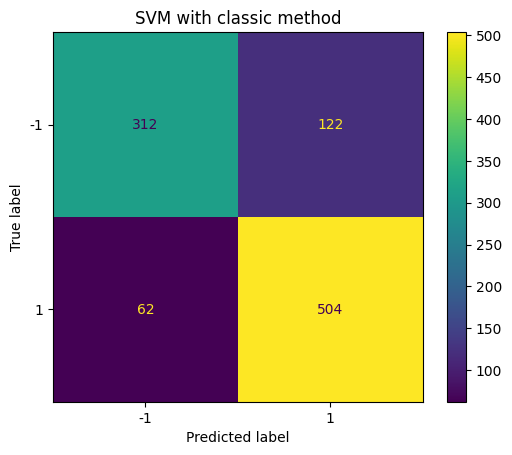

ACC = 0.816, F1 = 0.8456375838926175, PPV = 0.805111821086262, NPV = 0.8342245989304813, TPR = 0.8904593639575972, TNR = 0.7188940092165899, FPR = 0.28110599078341014, FNR = 0.10954063604240283

TP = 504, FP = 122, TN = 312, FN = 62


In [10]:
metricsClassic = EvaluateModel(model, Xts[:,3:], Yts, f"SVM with {model.method} method")


In [11]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictorTopological/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [12]:
model = model.FPcontrol(Xcal[:,3:], Ycal, epsilon,'ps')
model.get_params()

{'alpha': array([0.50000013, 0.5000364 , 0.50000945, ..., 0.49997145, 0.50001455,
        0.50000924]),
 'b': array([0.28015231]),
 'b_eps': 0.5024472807492978,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

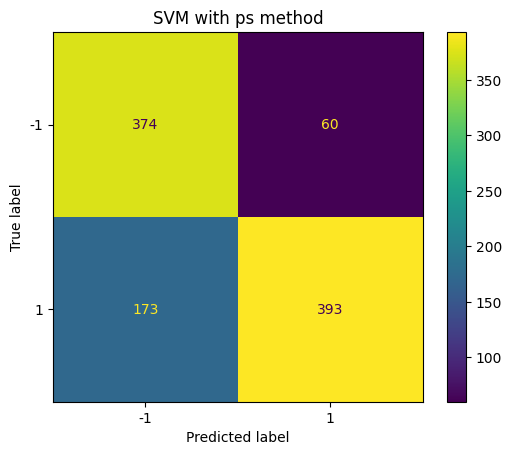

ACC = 0.767, F1 = 0.7713444553483808, PPV = 0.8675496688741722, NPV = 0.6837294332723949, TPR = 0.6943462897526502, TNR = 0.8617511520737328, FPR = 0.1382488479262673, FNR = 0.30565371024734983

TP = 393, FP = 60, TN = 374, FN = 173


In [13]:
metricsPSR = EvaluateModel(model, Xts[:,3:], Yts, f"SVM with {model.method} method")

In [36]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictorTopological/PS_SVM_safe.sav']

In [41]:
# save to file
y_ps_tr = model.predict(Xtr[:,3:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,3:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,3:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,3:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,3:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,3:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [37]:
model = model.FPcontrol(Xcal[:,3:], Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([ 4.99872383e-01, -2.30312013e-05, -7.37558808e-06, ...,
         5.00093371e-01,  5.00015073e-01, -1.54270367e-05]),
 'b': array([0.01518191]),
 'b_eps': 0.21313178659477316,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

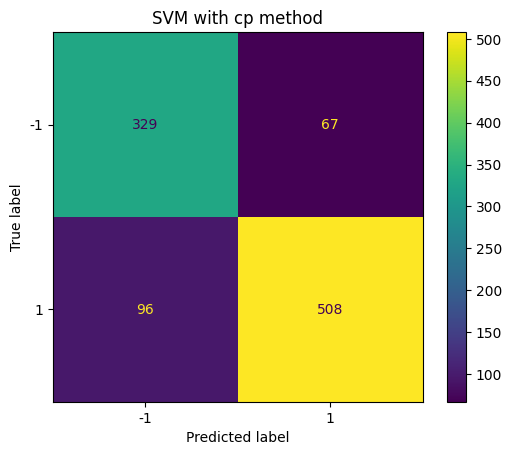

ACC = 0.837, F1 = 0.8617472434266328, PPV = 0.8834782608695653, NPV = 0.7741176470588236, TPR = 0.8410596026490066, TNR = 0.8308080808080808, FPR = 0.1691919191919192, FNR = 0.15894039735099338

TP = 508, FP = 67, TN = 329, FN = 96


In [38]:
metricsCSR = EvaluateModel(model, Xts[:,3:], Yts, f"SVM with {model.method} method")

In [39]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictorTopological/CP_SVM_safe.sav']

In [43]:
# save to file
y_ps_tr = model.predict(Xtr[:,3:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,3:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,3:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,3:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,3:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,3:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)